This is the notebook detailing the setup for reproducing the results from the paper 'Performance Variablity: Impact on Benchmarking and Algorithm Configuration'

The data used in this notebook is made available on zenodo: 

# Initialization

In [26]:
import numpy as np
import pickle
import pandas as pd
from functools import partial
import glob
import seaborn as sbs
import matplotlib.pyplot as plt

from scipy.stats import kendalltau, rankdata

font = {'size'   : 24}

plt.rc('font', **font)

#Font-requirement for GECCO
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
%load_ext rpy2.ipython

In [5]:
from rpy2 import robjects

In [7]:
%%R
library(data.table)
base_folder_R <- "/mnt/e/Research/Perf_Analysis/logs_baseline_cs/" #folder where the irace-runs are stored

In [8]:
%%R -o confs_all
confs_all <- rbindlist(lapply(seq(24), function(fid) {
    load(paste0(base_folder_R, "log_F", fid, "_5D_seed11"))
    iraceResults$allConfigurations
}))

In [22]:
dt_confs = pd.read_csv(f"Datatables/Irace_confs_static_modcma_v2.csv", index_col=0)
#dt_confs = pd.DataFrame(confs_all) #Alternative

In [9]:
base_folder = "/mnt/e/Research/Perf_analysis/irace_confs_static_modcma/" #folder where the verification runs are stored

In [11]:
%%R -o get_irace_info -o get_final_elites -o get_exp_results
get_irace_info <- function(fid, seed = 11) {
    load(paste0(base_folder_R, "log_F", fid, "_5D_seed", seed))
    return(as.data.table(iraceResults$experimentLog))
}

get_final_elites <- function(fid, seed=11) {
    load(paste0(base_folder_R, "log_F", fid, "_5D_seed", seed))
    return(iraceResults$allElites[[length(iraceResults$allElites)]])
}

get_exp_results <-  function(fid, seed=11) {
    load(paste0(base_folder_R, "log_F", fid, "_5D_seed", seed))
    return(iraceResults$experiments)
}

In [12]:
def load_verification(fid, type_ = 'aoc'):
    confs_one_func = dt_confs[dt_confs['fid'] == fid]
    idxs = confs_one_func.index
    IDs = confs_one_func['.ID.']
    perf_dict = {}
    for id_, idx in zip(IDs, idxs):
        dt_temp = pd.read_csv(f"{base_folder}idx_{idx-1}.csv", index_col=0)
        perf_dict[int(id_)] = list(dt_temp[type_])
    return perf_dict

In [13]:
def get_exp_log(fid, seed=11):
    exp_log = get_irace_info(fid, seed)
    dt_exp = pd.DataFrame(exp_log).transpose()
    dt_exp.columns = ['iter', 'instance', 'config', 'time', 'bound']
    dt_exp['instance'] = dt_exp['instance'] - 1
    dt_exp['iter'] = dt_exp['iter'] - 1
    dt_exp['iter'] = pd.to_numeric(dt_exp['iter'], downcast='integer')
    dt_exp['instance'] = pd.to_numeric(dt_exp['instance'], downcast='integer')
    dt_exp['config'] = pd.to_numeric(dt_exp['config'], downcast='integer')
    return dt_exp.drop(['time', 'bound'], axis=1)

# Simulations

## Simulate Racing Procedures

### Initialization

In [ ]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

import itertools
flatten = itertools.chain.from_iterable

In [ ]:
%%R

aux.ttest <- function(results, alive, which.alive, conf.level,
                      adjust = c("none","bonferroni","holm"))
{
  adjust <- match.arg(adjust)
#   irace.assert(sum(alive) == length(which.alive))
  
  results <- results[, which.alive]
  means <- colMeans(results)
  best <- which.min(means)
  mean_best <- means[best]
  pvals <- sapply(means, function(x) as.numeric(isTRUE(
                                       all.equal.numeric(mean_best[[1]], x[[1]], check.attributes = FALSE))))
  results_best <- results[, best]
  var_best <- var(results_best)
  which_test <- which(pvals < 1.0)
  for (j in which_test) {
    PVAL <- pvals[j]
    if (PVAL == 1.0) next
    results_j <- results[ , j]
    # t.test may fail if the data in each group is almost constant. Hence, we
    # surround the call in a try() and we initialize p with 1 if the means are
    # equal or zero if they are different
    if (min(var(results_best), var(results_j)) < 10 * .Machine$double.eps) next
    try(PVAL <- t.test(results_best, results_j, paired = TRUE)$p.value)
#     irace.assert(!is.nan(PVAL) & !is.na(PVAL))
    pvals[j] <- PVAL
  }
  pvals <- p.adjust(pvals, method = adjust)
  dropj <- which.alive[pvals < 1.0 - conf.level]
  dropped_any <- length(dropj) > 0
#   irace.assert(all(alive[dropj]))
  alive[dropj] <- FALSE
  return(list(best = which.alive[best], ranks = means, alive = alive,
              dropped.any = dropped_any, p.value = min(pvals)))
}

In [ ]:
%%R -o get_alive
# random_samples
get_alive <-function(samples, ids, ids_alive) {
#     print(samples)
    return(aux2.friedman(samples, unlist(ids), unlist(ids_alive), 0.95)$alive)
}

In [ ]:
%%R -o get_alive_ttest
get_alive_ttest <-function(samples, ids, ids_alive) {
    return(aux.ttest(samples, unlist(ids), unlist(ids_alive), 0.95, "none")$alive)
}

In [ ]:
%%R
aux2.friedman <- function(y, I, alive, conf.level = 0.95)
{
  dropped.any <- FALSE
  n <- nrow(y)
  k <- length(I)
  r <- t(apply(y[,I], 1L, rank))
  R <- colSums(r)
  o <- order(R)
  best <- I[o[1]]
  TIES <- tapply(r, row(r), table)
  STATISTIC <- ((12 * sum((R - n * (k + 1) / 2)^2)) /
                (n * k * (k + 1)
                  - (sum(unlist(lapply(TIES, function (u) {u^3 - u}))) /
                     (k - 1))))
  PARAMETER <- k - 1
  PVAL      <- pchisq(STATISTIC, PARAMETER, lower.tail = FALSE)
  #names(STATISTIC) <- "Friedman chi-squared"
  #names(PARAMETER) <- "df"

  alpha <- 1 - conf.level
  if (!is.nan(PVAL) && PVAL < alpha) {
    # This formula for multiple comparisons comes from Conover, "Practical
    # Nonparametric Statistics", 1999, pages 369-371.
    A <- sum(as.vector(r)^2)
    t <- qt(1 - alpha / 2, df = (n - 1) * (k - 1)) *
      (2 * (n * A - sum(R^2)) / ((n - 1) * (k - 1)))^(1 / 2)
    J <- best
    for (j in 2:k) {
      if (abs(R[o[j]] - R[o[1]]) > t) {
        break
      } else {
        J <- c(J, I[o[j]])
      }
    }
    alive[-J] <- FALSE
    dropped.any <- TRUE
  }
#   print(I[which.min(R)] == best)
  return(list(best = best, ranks = R, alive = alive, dropped.any = dropped.any, p.value = PVAL))
}

In [ ]:
%%R -o get_alive_halving
get_alive_halving <- function(samples, ids, ids_alive) {
    return(aux.ttest(samples, unlist(ids), unlist(ids_alive), 0.95, "none")$alive)
}

### Collect Data

In [ ]:
def simulate_last_race(fid, ss = 2, reps = 1000, type_ = 'aoc', test='f-test'):
    perf_dict = load_verification(fid, type_)
    kept_alive = np.zeros((33,))
    max_val = max(perf_dict.keys())
    true_means = np.array([np.mean(perf_dict[x]) for x in range(max_val-33,max_val)])
    
    full_dict = {}
    
    for rep in range(reps):
        random_samples = np.array([np.random.choice(perf_dict[x], size=ss, replace=True) for x in range(max_val-33,max_val)]).transpose()
        random_samples_ = random_samples
        if test == 'f-test':
            alive = get_alive(robjects.r.matrix(random_samples, nrow=random_samples.shape[0], ncol=random_samples.shape[1]), robjects.r.matrix([i for i in range(1,34)]), robjects.r.matrix([i for i in range(1,34)]))
        else:
            alive = get_alive_ttest(robjects.r.matrix(random_samples, nrow=random_samples.shape[0], ncol=random_samples.shape[1]), robjects.r.matrix([i for i in range(1,34)]), robjects.r.matrix([i for i in range(1,34)]))
        alive_ = list([i-1 for i in alive if i != 0])
        ss_new = ss
        used_samples = ss*33
        while len(alive_) > 5:
            used_samples = used_samples + len(alive_)
            ss_new = ss_new + 1
            random_samples_ = np.zeros((ss_new, 33))
            random_samples_[:(ss_new-1), :] = random_samples
            random_samples_[(ss_new-1), :] = [np.random.choice(perf_dict[x], size=1, replace=True) for x in range(max_val-33,max_val)]
            random_samples = random_samples_
            if test == 'f-test':
                alive = get_alive(robjects.r.matrix(random_samples, nrow=random_samples.shape[0], ncol=random_samples.shape[1]), robjects.r.matrix([i for i in range(1,34)]), robjects.r.matrix(alive))
            else:
                alive = get_alive_ttest(robjects.r.matrix(random_samples, nrow=random_samples.shape[0], ncol=random_samples.shape[1]), robjects.r.matrix([i for i in range(1,34)]), robjects.r.matrix(alive))
            alive_ = list([i-1 for i in alive if i != 0])
            if used_samples > 10000:
                print("exceed 10k")
                break        
        alive_ = np.array(alive_).flatten()
        kept_alive[alive_] += 1
        
#         print(alive_)
#         print(random_samples_.shape)
        means_alive = np.mean(random_samples_[:,alive_], axis=0)
        true_means_alive = true_means[alive_]
        underestimations = [1-x/y for x,y in zip(means_alive, true_means_alive)]
        overall_underestimation = 1-np.min(means_alive)/np.min(true_means_alive)
        performance_loss = 1-np.min(true_means)/true_means_alive[np.argmin(means_alive)]
        info_dict = {'race_means' : means_alive, 'true_means' : true_means_alive, 'underestimations' : underestimations,
                    'overall_underestimation' : overall_underestimation, 'used_samples' : used_samples,
                    'performance_loss' : performance_loss, 'test_type' : test}
        full_dict[rep] = info_dict
        
    return kept_alive, full_dict

In [ ]:
#Repeat with different test-parameters for the other cases
records_overall = []

for fid in range(1,25):
    for sample_size in [2,5,10,15,25,50]:
        rres, full_dict = simulate_last_race(fid, sample_size, reps=1000, type_ = 'aoc', test='t-test')
        for k,v in full_dict.items():
            records_overall.append([fid, sample_size, k, v['performance_loss'], v['overall_underestimation'], v['used_samples']])

In [ ]:
dt_overall_perf_ttest = pd.DataFrame.from_records(records_overall, columns = ["Fid", "Sample Size", "rep", "Perf Loss", "Underestimation", "Used Samples"])

## Pairwise comparisons

These experiments have their own .py files: 'modcma_mistake_baseline.py' and 'modcma_mistake_calc.py'

## Successive Halving

In [ ]:
def simulate_succ_halving(fid, ss = 2, reps = 1000, type_ = 'aoc', R=3):
    perf_dict = load_verification(fid, type_)
    kept_alive = np.zeros((33,))
    max_val = max(perf_dict.keys())
    true_means = np.array([np.mean(perf_dict[x]) for x in range(max_val-33,max_val)])
    
    full_dict = {}
    
    for rep in range(reps):
        random_samples = np.array([np.random.choice(perf_dict[x], size=ss, replace=True) for x in range(max_val-33,max_val)]).transpose()
        random_samples_ = random_samples

        means = np.mean(random_samples_, axis=0)
        alive = np.argsort(means)[:int(np.ceil(33/R))]
        alive_ = alive
        used_samples = 33*ss
        ss_new = ss
        ss_total = ss

        while len(alive_) > 1:
#             print(used_samples, len(alive_))
            ss_old = ss_new
            ss_new = ss_old * 2
            ss_total = ss_total + ss_new
#             print(ss_old, ss_new, ss_total)
            used_samples += ss_new*len(alive_)
#             print(used_samples)
            random_samples_ = np.zeros((ss_total, 33))
            
            random_samples_[:(ss_total-ss_new), :] = random_samples
            random_samples_[(ss_total-ss_new):, :] = np.transpose(np.array([np.random.choice(perf_dict[x], size=ss_new, replace=True) for x in range(max_val-33,max_val)]))
            
            random_samples = random_samples_
            means = np.mean(random_samples_, axis=0)
            alive = [alive_[x] for x in np.argsort(means[alive_])[:int(np.ceil(len(alive_)/R))]]
            alive_ = alive
            
        kept_alive[alive_] += 1
        

        means_alive = np.mean(random_samples_[:,alive_], axis=0)
        true_means_alive = true_means[alive_]
        underestimations = [1-x/y for x,y in zip(means_alive, true_means_alive)]
        overall_underestimation = 1-np.min(means_alive)/np.min(true_means_alive)
        performance_loss = 1-np.min(true_means)/true_means_alive[np.argmin(means_alive)]
        info_dict = {'race_means' : means_alive, 'true_means' : true_means_alive, 'underestimations' : underestimations,
                    'overall_underestimation' : overall_underestimation, 'used_samples' : used_samples,
                    'performance_loss' : performance_loss, 'test_type' : f'SHA-{R}'}
        full_dict[rep] = info_dict
        
    return kept_alive, full_dict

In [ ]:
records_overall = []

for fid in range(1,25):
    print(fid)
    for sample_size in [2,5,10,15,25,50]:
        for R in [2,3]:
            rres, full_dict = simulate_succ_halving(fid, sample_size, reps=1000, type_ = 'aoc', R=R)
            for k,v in full_dict.items():
                records_overall.append([fid, sample_size, k, v['performance_loss'], v['overall_underestimation'], v['used_samples'], v['test_type']])

In [ ]:
dt_halving = pd.DataFrame.from_records(records_overall, columns = ["Fid", "Sample Size", "rep", "Perf Loss", "Underestimation", "Used Samples", "Type"])

# Figures

## Figure 1: BBOB AOC Values

In [64]:
bbob_data_folder = "/mnt/e/Research/Perf_analysis/BBOB_v2/"

def plot_overview_table(fid, dim, kind='AOC', savefig=False):
    dt = pd.read_csv(f"{bbob_data_folder}{kind}_F{fid}_{dim}D.csv", index_col=0)
    plt.figure(figsize=(19,10))
    y_var = 'aocs' if kind == 'AOC' else 'RT'
    x_var = 'algid' if kind == 'AOC' else 'algId'
    algnames = [a for a in np.unique(dt[x_var]) if not all(np.isnan(dt[dt[x_var] == a][y_var]))]
    dt_plot = dt[dt[x_var].isin(algnames)]
    sbs.stripplot(data=dt_plot, x=x_var, y=y_var)
    plt.xticks(rotation=90, fontsize=12)
    for i in range(len(plt.xticks()[0])):
        plt.axvline(i+0.5, color='k', ls=':')
    plt.yscale('log')
    plt.ylabel("AOC")
    plt.tight_layout()
    if savefig:
        plt.savefig(f"Figures_reproduced//{kind}_Distr_BBOB_algs_F{fid}_{dim}D.pdf")
        plt.close()
    else:
        plt.show()

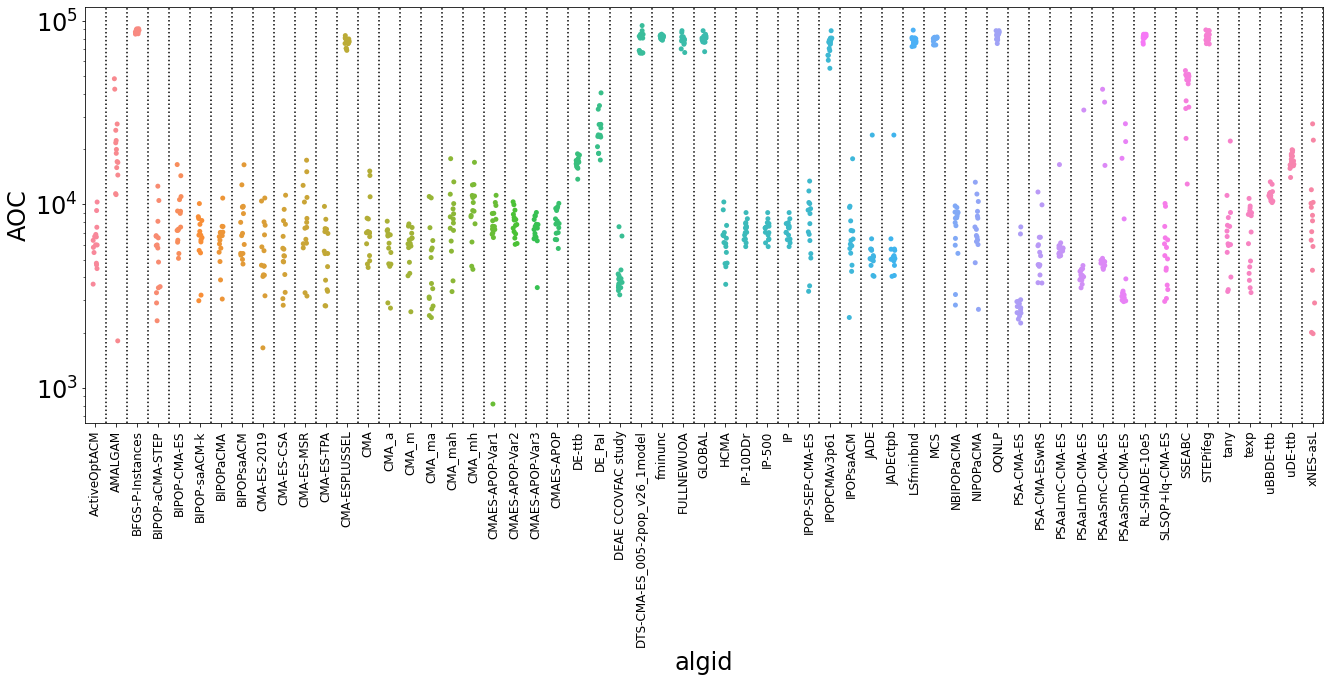

In [65]:
plot_overview_table(18, 5, 'AOC')

## Figure 2: Rank correlation

In [31]:
def plot_rank_correlation(fid, ss, use_rank = True, use_scatter = False, limit = True, figname = None):
    perf_dict = load_verification(fid)
    means = [np.mean(x) for x in perf_dict.values()]
    
    np.random.seed(42) #For reproducibility
#     temp_mat = np.array(get_exp_results(fid, 11))
    means_r = [np.mean(np.random.choice(x, ss, True)) for x in perf_dict.values()]
    
    if limit:
        means = means[:33]
        means_r = means_r[:33]
    
    plt.figure(figsize=(16,6))
    if use_rank:
        for i,j in zip(rankdata(means), rankdata(means_r)):
            plt.plot((i,j), range(2), alpha=0.5, color='k')
            plt.yticks([0,1], ['Original Means', 'Resampled Means'])
    else:
        if use_scatter:
            sbs.regplot(x=means, y=means_r)
            lims = [
                np.min([plt.xlim(), plt.ylim()]),  # min of both axes
                np.max([plt.xlim(), plt.ylim()]),  # max of both axes
            ]
            plt.plot(lims, lims, color='k', ls='--')
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel("Original Means")
            plt.ylabel("Resampled Means")
        else:
            for i,j in zip(means, means_r):
                plt.plot((i,j), range(2), alpha=0.5, color='k')
            plt.xscale('log')
            plt.yticks([0,1], ['Mean', 'Means_Irace'])
    plt.tight_layout()
    if figname:
        plt.savefig(f"Figures_reproduced/{figname}.pdf")
    plt.show()
    print(f"Kendall Tau correlation: {kendalltau(means, means_r)}")

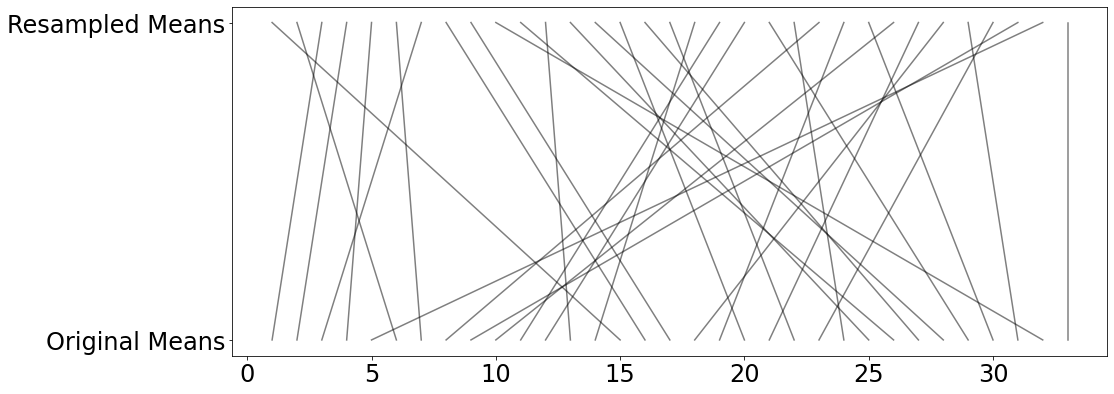

Kendall Tau correlation: KendalltauResult(correlation=0.25, pvalue=0.041713549944169155)


In [32]:
plot_rank_correlation(21, 15, True, False, figname="Rank_change_F21_15ss")

## Figure 3: Evolution of Means

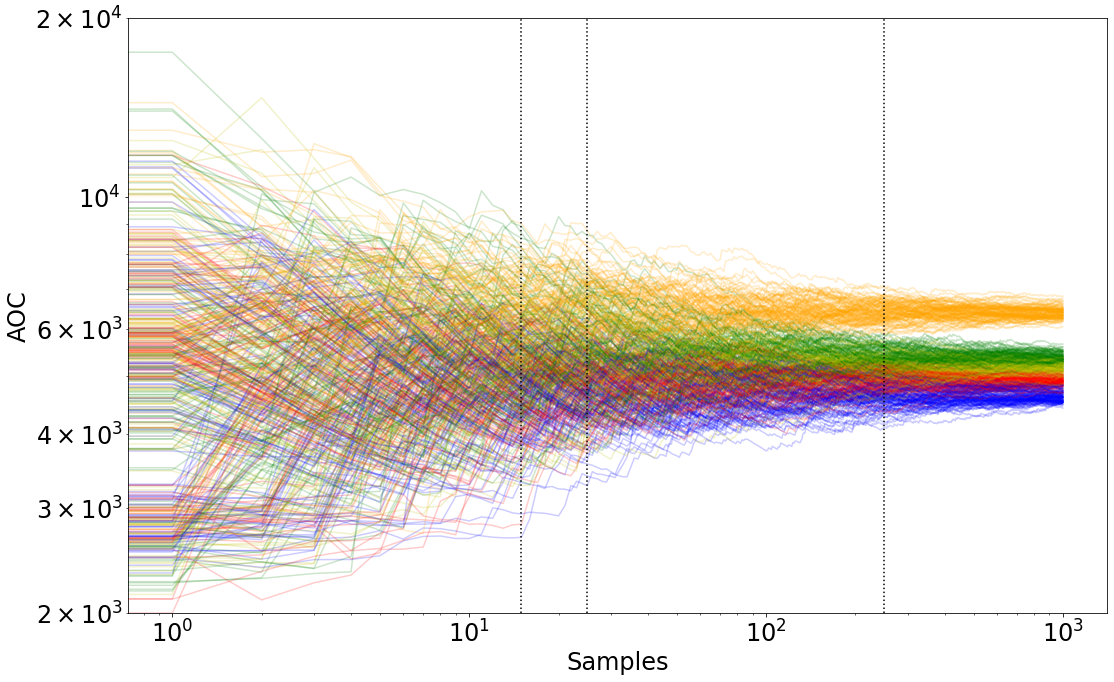

In [49]:
#Can change which confs are seleced by changing it in aocs1,2...
fid = 18
perf_dict = load_verification(fid)
means = [np.mean(x) for x in perf_dict.values()]
min_args = np.argsort(means)


plt.figure(figsize=(16,10))
for rep in range(100):
    #very ugly code, update!
    aocs1 = np.random.choice(perf_dict[min_args[1]+1], size=1000, replace=True)
    aocs2 = np.random.choice(perf_dict[min_args[3]+1], size=1000, replace=True)
    aocs3 = np.random.choice(perf_dict[min_args[5]+1], size=1000, replace=True)
    plt.plot(range(1000), [x/(i+1) for i,x in enumerate(np.cumsum(aocs1))], color='b', alpha=0.2)
    plt.plot(range(1000), [x/(i+1) for i,x in enumerate(np.cumsum(aocs2))], color='r', alpha=0.2)
    plt.plot(range(1000), [x/(i+1) for i,x in enumerate(np.cumsum(aocs3))], color='y', alpha=0.2)

    aocs4 = np.random.choice(perf_dict[min_args[10]+1], size=1000, replace=True)
    plt.plot(range(1000), [x/(i+1) for i,x in enumerate(np.cumsum(aocs4))], color='g', alpha=0.2)

    aocs5 = np.random.choice(perf_dict[min_args[15]+1], size=1000, replace=True)
    plt.plot(range(1000), [x/(i+1) for i,x in enumerate(np.cumsum(aocs5))], color='orange', alpha=0.2)
plt.yscale('log')
plt.xscale('log')
# plt.axhline(np.mean(aocs), color='k', ls=':')
plt.axvline(15, color='k', ls=':')
plt.axvline(25, color='k', ls=':')
plt.axvline(250, color='k', ls=':')
plt.xlabel("Samples")
plt.ylabel("AOC")
plt.ylim(2000,20000)
plt.tight_layout()
plt.savefig(f"Figures_reproduced//Mean_over_time_modcma_selected_confs_F{fid}.pdf")

## Figure 4: performance loss of all irace generated configurations

In [16]:
def get_perf_loss_irace_all(fid):
    log = get_exp_results(fid)
    verif = load_verification(fid)
    conf_nr = np.nanargmin(np.mean(np.array(log), axis=0), )
    elts = np.array(get_final_elites(fid))
    if conf_nr+1 not in elts:
        print(f"F{fid} issue: conf {conf_nr+1} not in elts {elts}")
#     real_value = np.mean(verif[conf_nr+1])
    real_means = [np.mean(x) for x in verif.values()]
    real_value = real_means[conf_nr]
    best_value = np.min(real_means)
    perf_losses = [1-best_value/x for x in real_means]#real_value
    return perf_losses, elts

In [24]:
dt_perfloss = pd.DataFrame()
for fid in range(1,25):
    x, elts = get_perf_loss_irace_all(fid)
    dt_temp = pd.DataFrame(x)
    elite = [x2+1 in elts for x2 in range(len(x))]
    dt_temp['Elite'] = elite
    dt_temp['Fid'] = fid
    dt_perfloss = dt_perfloss.append(dt_temp)
dt_perfloss.columns = ['Perf Loss', 'Elite', 'Fid']

/home/diedi/.local/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


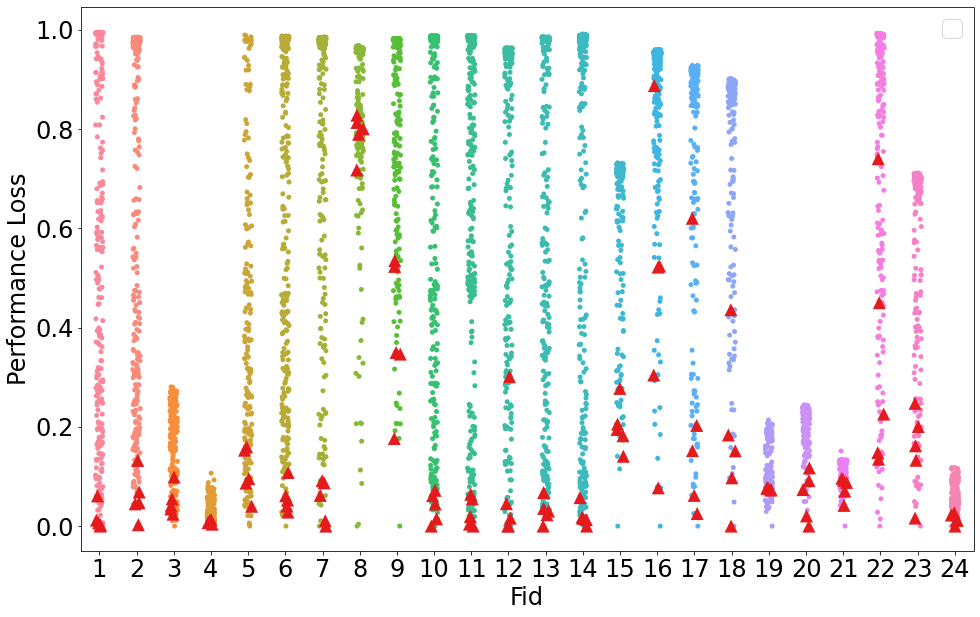

In [29]:
plt.figure(figsize=(16,10))
sbs.stripplot(data=dt_perfloss, x='Fid', y='Perf Loss')
dt_elt = dt_perfloss[dt_perfloss['Elite']]
sbs.stripplot(data=dt_elt, x='Fid', y='Perf Loss', hue='Elite', s=13, palette=sbs.color_palette("Set1"), marker='^')
plt.legend([])
plt.ylabel("Performance Loss")
plt.savefig("Figures_reproduced/Irace_all_perfloss.pdf")

## Figure 5 + 6: Performance Loss and Underestimation when using Means

In [ ]:
records = []
for fid in range(1,25):
    perf_dict = load_verification(fid)
    max_val = max(perf_dict.keys())
    true_means = np.zeros(33)
    for i in range(33):
        true_means[i] = np.mean(perf_dict[max_val-i])
#     true_means = np.array([np.mean(perf_dict[x]) for x in range(max_val-33,max_val)])
    best_true_mean = np.min(true_means)
    
    for ss in [2,5,10,15,25,50]:
        samples = np.zeros((33, ss))
        for _ in range(5000):
            for i in range(33):
                samples[i] = np.random.choice(perf_dict[max_val-i], ss, True)
            means = np.mean(samples, axis=1)
            sel_idx = np.argmin(means)
            underestimation = 1-means[sel_idx]/true_means[sel_idx]
            perf_loss = 1-best_true_mean/true_means[sel_idx]
            records.append([fid, ss, underestimation, perf_loss, kendalltau(means, true_means)])

In [ ]:
df_group_selection_mean_larger = pd.DataFrame.from_records(records, columns=['Fid', 'Sample Size', 'Underestimation', 'Perf Loss', 'Kendall Tau'])
#Alternative: df_group_selection_mean_larger = pd.read_csv("Datatables/df_group_selection_mean_fixed.csv")

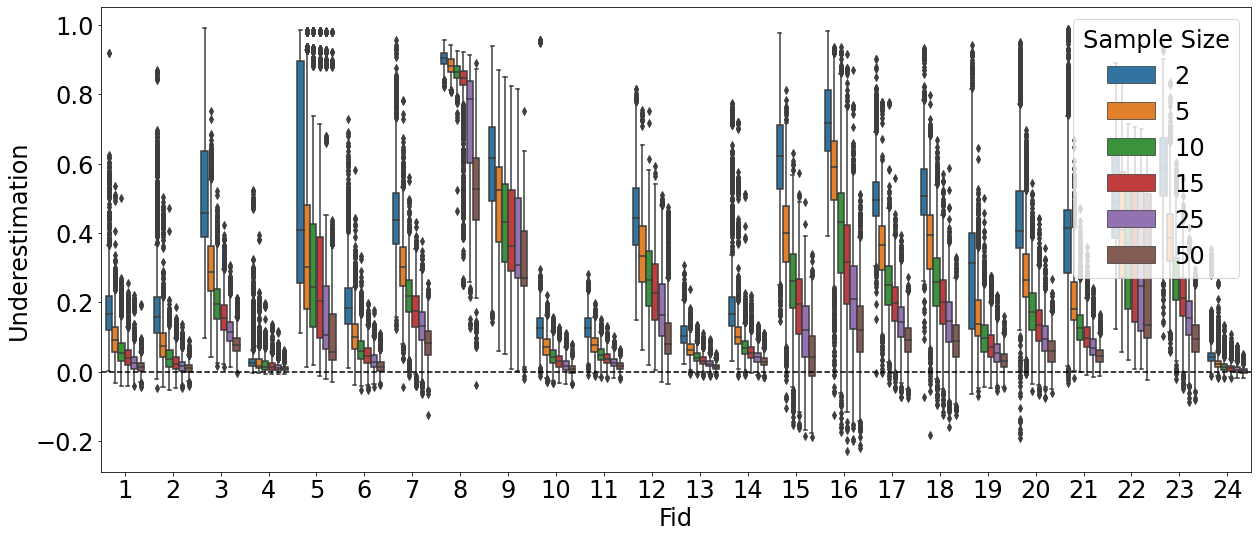

In [89]:
plt.figure(figsize=(18,8))
sbs.boxplot(data=df_group_selection_mean_larger, x='Fid', y='Underestimation', hue='Sample Size')
plt.axhline(0, c='k', ls='--')
plt.tight_layout()
plt.savefig("Figures_reproduced//Underestimation_selection_group_mean.pdf")

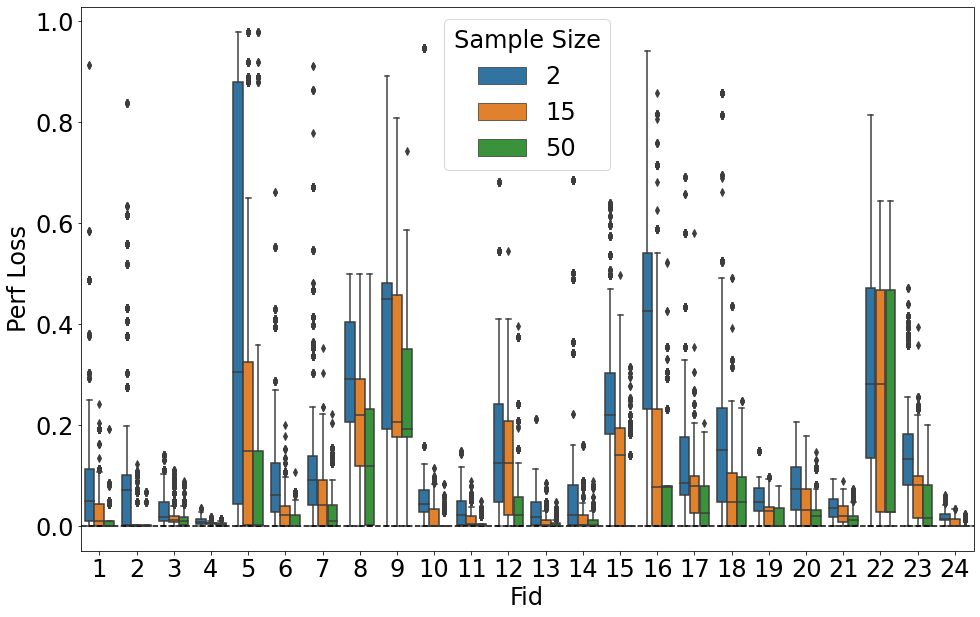

In [69]:
plt.figure(figsize=(16,10))
sbs.boxplot(data=df_group_selection_mean_larger[df_group_selection_mean_larger['Sample Size'].isin([2,15,50])], x='Fid', y='Perf Loss', hue='Sample Size')
plt.axhline(0, c='k', ls='--')
plt.savefig("Figures_reproduced//Perf_loss_selection_group_mean.pdf")

## Figure 7: AOC Distribution on F8

In [41]:
def plot_conf_distr(fid, race_nr = -1, type_ = 'aoc'):
    perf_dict = load_verification(fid, type_)
    dt_perf = pd.DataFrame(perf_dict)
    if race_nr == -1:
        max_val = max(perf_dict.keys())
        idx_start = max_val-33
        idx_end = max_val
    else:
        idx_start = 33*race_nr
        idx_end = 33*(race_nr+1)
    dt_plot = dt_perf.iloc[:,range(idx_start,idx_end)].melt()
    means = [np.mean(x) for x in perf_dict.values()][idx_start: idx_end]
    true_order = np.argsort(means)+idx_start+1
    
    plt.figure(figsize=(19,10))
    sbs.stripplot(data=dt_plot, x='variable', y='value', order=true_order)
    plt.xticks(rotation=90)
    plt.xlabel("Configuration number")
    plt.ylabel("Hitting time")
    plt.yscale('log')
    plt.plot(np.sort(means))
    plt.tight_layout()
    plt.savefig(f"Figures_reproduced/Scatter_F{fid}_configs_race_{race_nr}_{type_}.pdf")

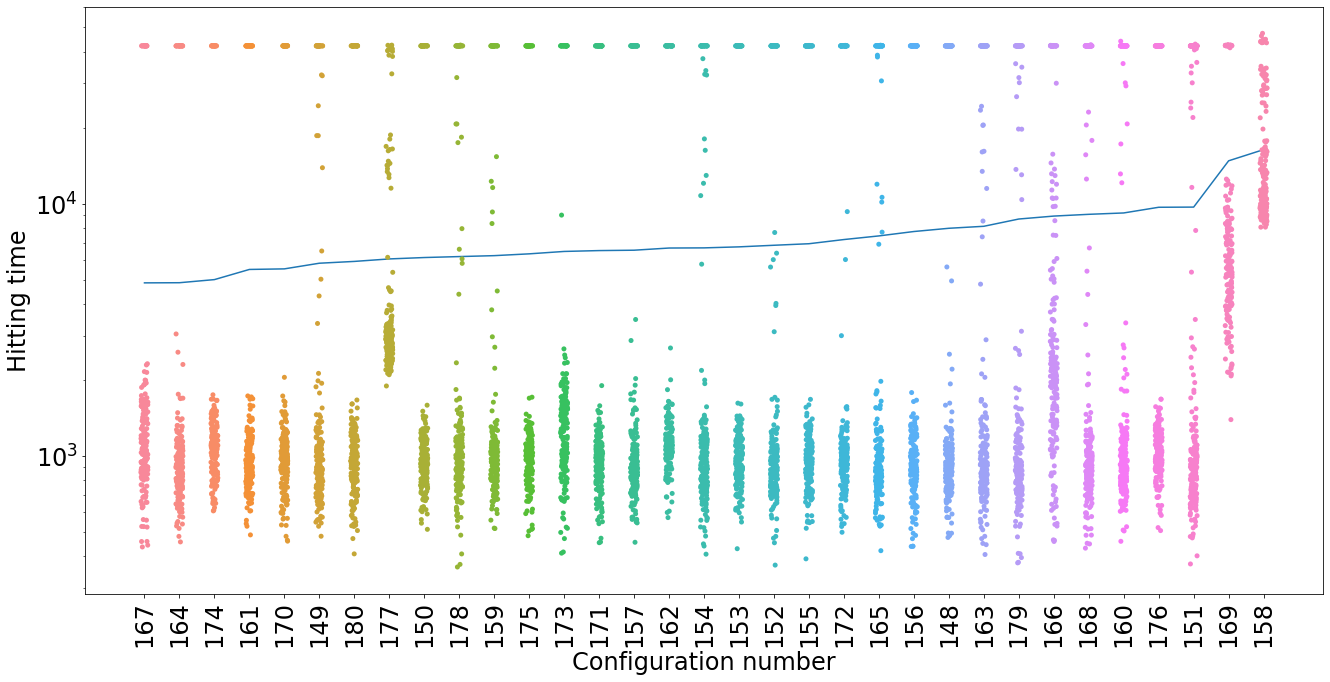

In [42]:
plot_conf_distr(8)

## Figure 8: Scatter of Pairwise Decisions based on Means

In [71]:
def plot_comp_vs_baseline_scatter(fid, ss, testname, tname):
    dt = pd.read_csv(f"Datatables/F{fid}_cma_mistakes.csv", index_col=0)
    dt_base = pd.read_csv(f"Datatables/F{fid}_cma_mistakes_normal.csv", index_col=0)
    dt['t_wrong'] = 1-dt.t_nan-dt.t_correct
    dt['w_wrong'] = 1-dt.w_nan-dt.w_correct
    dt['m_wrong'] = 1-dt.mean_correct

    dt_base['t_wrong'] = 1-dt_base.t_nan-dt_base.t_correct
    dt_base['w_wrong'] = 1-dt_base.w_nan-dt_base.w_correct
    dt_base['m_wrong'] = 1-dt_base.mean_correct

    dt_temp = dt[(dt['ss'] == ss)]
    dt_temp_base = dt_base[(dt_base['ss'] == ss)]
    max_len = len(dt_temp)
#         axes[fid-1, ss_idx].scatter(dt_temp['Mean difference'], dt_temp['mean_correct'], s=1, alpha=0.1)

    plt.figure(figsize=(16,10))
    plt.scatter(dt_temp['Mean difference'], dt_temp[tname], s=8, alpha=0.7, label=f'Original Samples')
    plt.scatter(dt_temp_base['Mean difference'], dt_temp_base[tname], s=8, alpha=0.7, label=f'Normal Distributions')
    plt.legend()
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.xlabel("Mean Difference")
    plt.ylabel("Fraction correct")
#     plt.xticks()
#         axes[fid-1, ss_idx].set_xticklabels([f"{x:.0f}" for x in [0,1]], fontsize=8)
#             axes[fid-1, ss_idx].set_xticks(range(len(bins))[::5])
#             axes[fid-1, ss_idx].set_xticklabels([f"{x:.2f}" for x in bins[::5]], fontsize=8)

#     axes[fid-1, 0].set_ylabel(f'F{fid}')
#     axes[fid-1, 0].set_yticks([0,1])
#     axes[fid-1, 0].set_yticklabels([f"{x:.0f}" for x in [0,1]], fontsize=8)

    #             axes[fid-1, ss_idx].hist(dt_full[(dt_full['Sample Size'] == ss) & (dt_full['Fid'] == fid)]['Underestimation'])#, split=True, cut=0, inner = 'quartile')
#     fig.set_figheight(26)
#     fig.set_figwidth(15)
    plt.tight_layout()
#     plt.subplots_adjust(hspace=0.03, wspace=0.03)
    plt.savefig(f"Figures_reproduced/F{fid}_S{ss}_{testname}_vs_baseline.pdf")

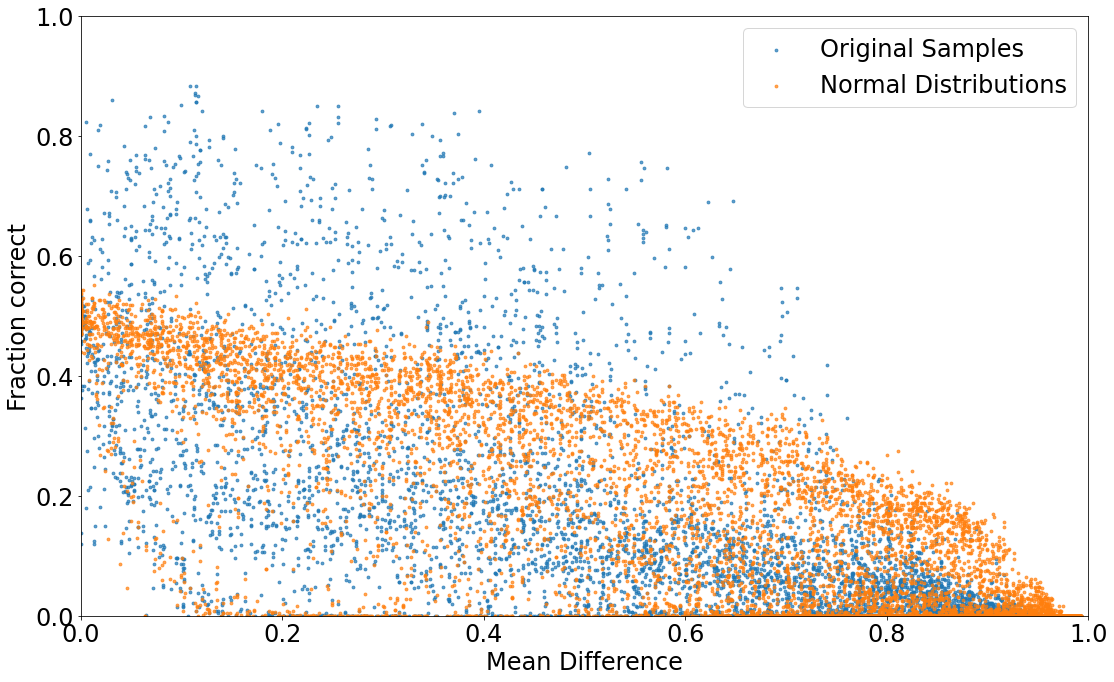

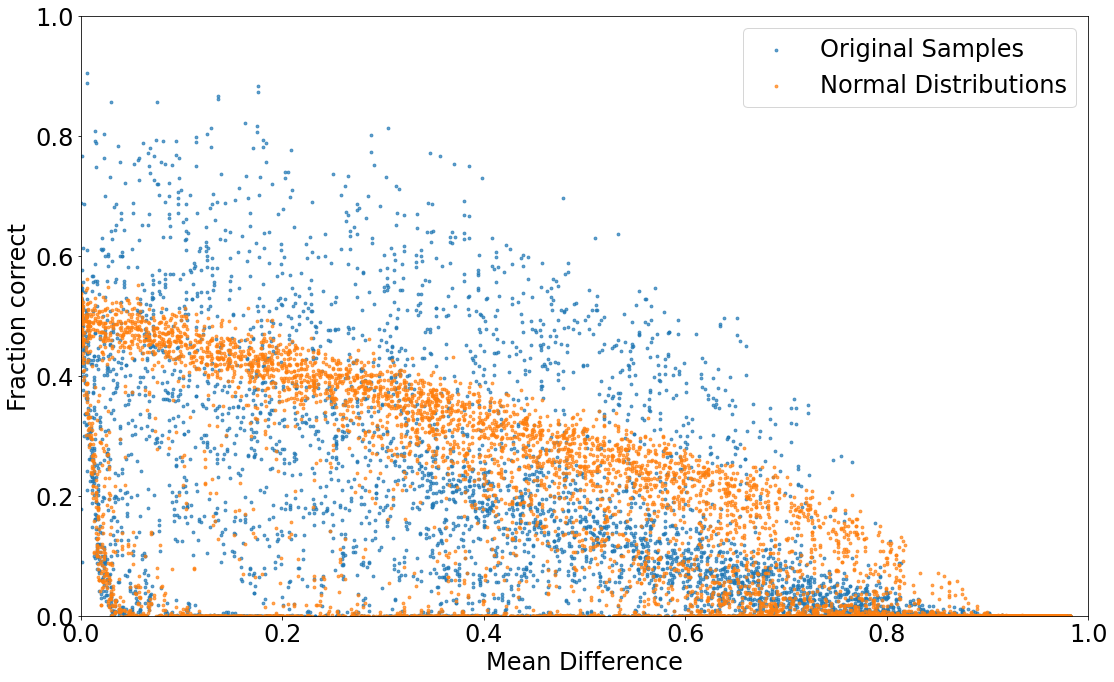

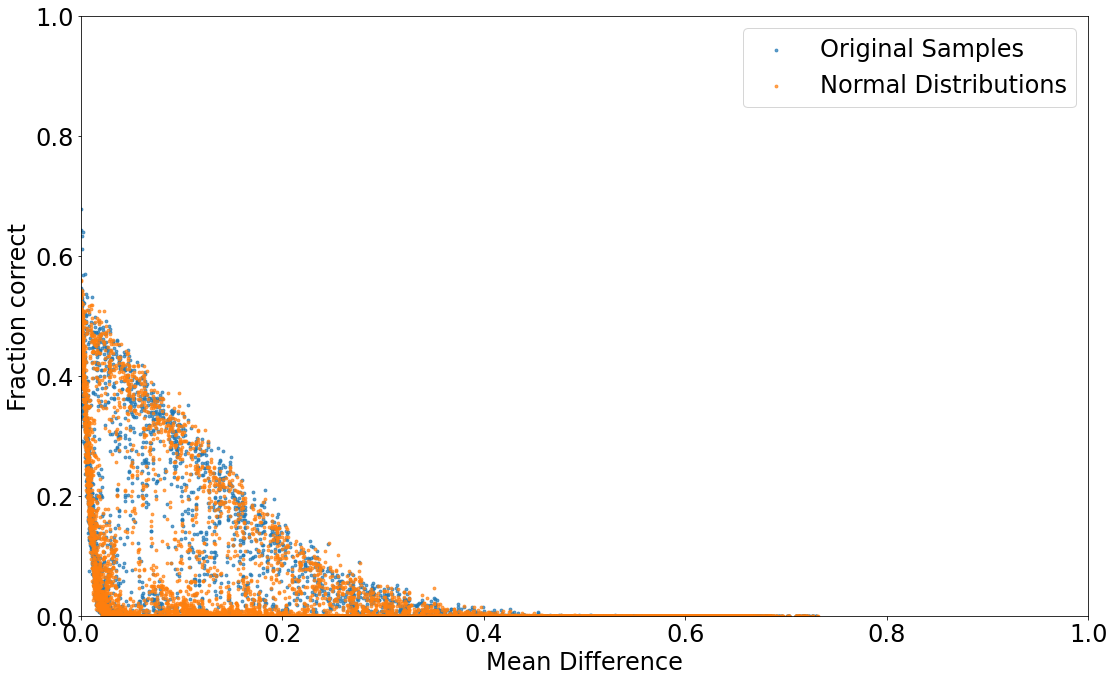

In [72]:
plot_comp_vs_baseline_scatter(22, 15, 'Mean', 'm_wrong')
plot_comp_vs_baseline_scatter(9, 15, 'Mean', 'm_wrong')
plot_comp_vs_baseline_scatter(15, 15, 'Mean', 'm_wrong')

## Figure 9: Barplots of 3 Pairwise Tests 

In [73]:
def plot_binned_aggr(fid, ss, test='t', n_bin=100):
    dt = pd.read_csv(f"Datatables/F{fid}_cma_mistakes.csv", index_col=0)
    dt['t_wrong'] = 1-dt.t_nan-dt.t_correct
    dt['w_wrong'] = 1-dt.w_nan-dt.w_correct
    dt['m_wrong'] = 1-dt.mean_correct
    dt['m_correct'] = dt.mean_correct
    dt['m_nan'] = 0
    dt = dt[dt['ss'] == ss]

    bins = np.arange(0,1.00001,1/n_bin)
    res = np.zeros((n_bin, 3))
    i=0
    for i, (low, high) in enumerate(zip(bins[:-1], bins[1:])):
        dt_temp = dt[(dt['Mean difference'] < high) & (dt['Mean difference'] >= low)]
        res[i,0] = np.mean(dt_temp[f'{test}_nan'])
        res[i,1] = np.mean(dt_temp[f'{test}_wrong'])
        res[i,2] = np.mean(dt_temp[f'{test}_correct'])
    plt.figure(figsize=(16,10))
    plt.bar(range(len(bins)-1),res[:,1], label='wrong', color='r', width=1)
    plt.bar(range(len(bins)-1),res[:,0], bottom=res[:,1], label='nan', width=1)
    plt.bar(range(len(bins)-1),res[:,2], bottom=res[:,1]+res[:,0], label = 'correct', color='g', width=1)
    plt.legend()
    plt.ylim(0,1)
    plt.axhline(0.05, c='k', ls='--')
    plt.xticks(range(len(bins))[::10], [f"{x:.1f}" for x in bins[::10]])
    plt.xlim(-0.5,100)
    plt.tight_layout()
    plt.savefig(f"Figures_reproduced//Binned_runs/F{fid}_S{ss}_{test}-test.pdf")

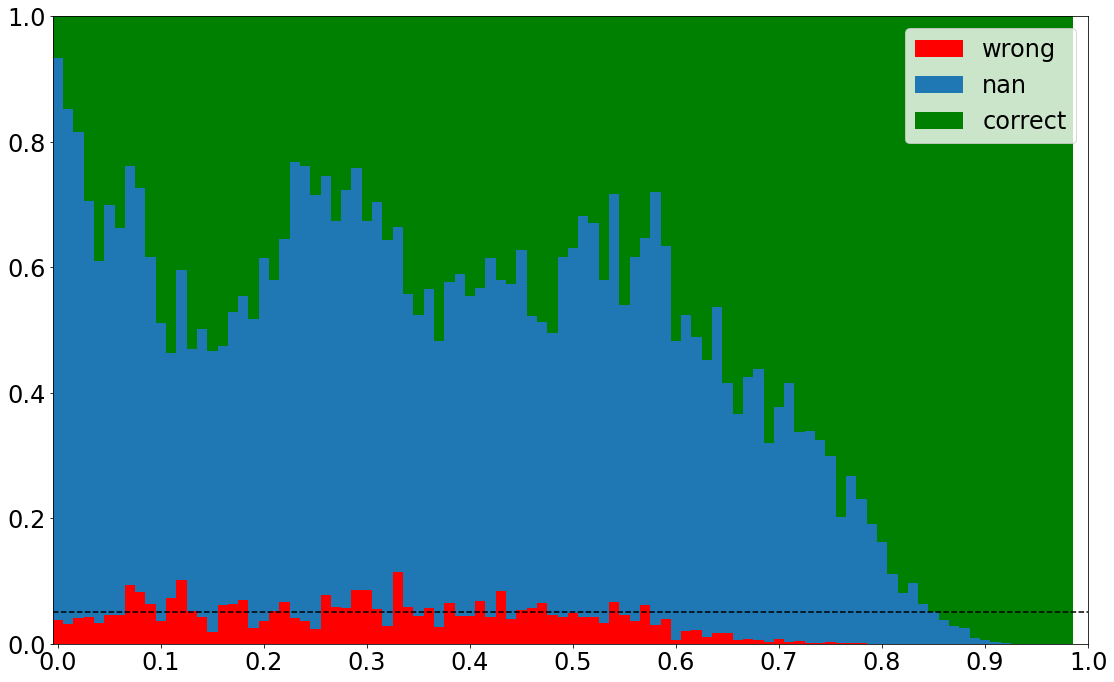

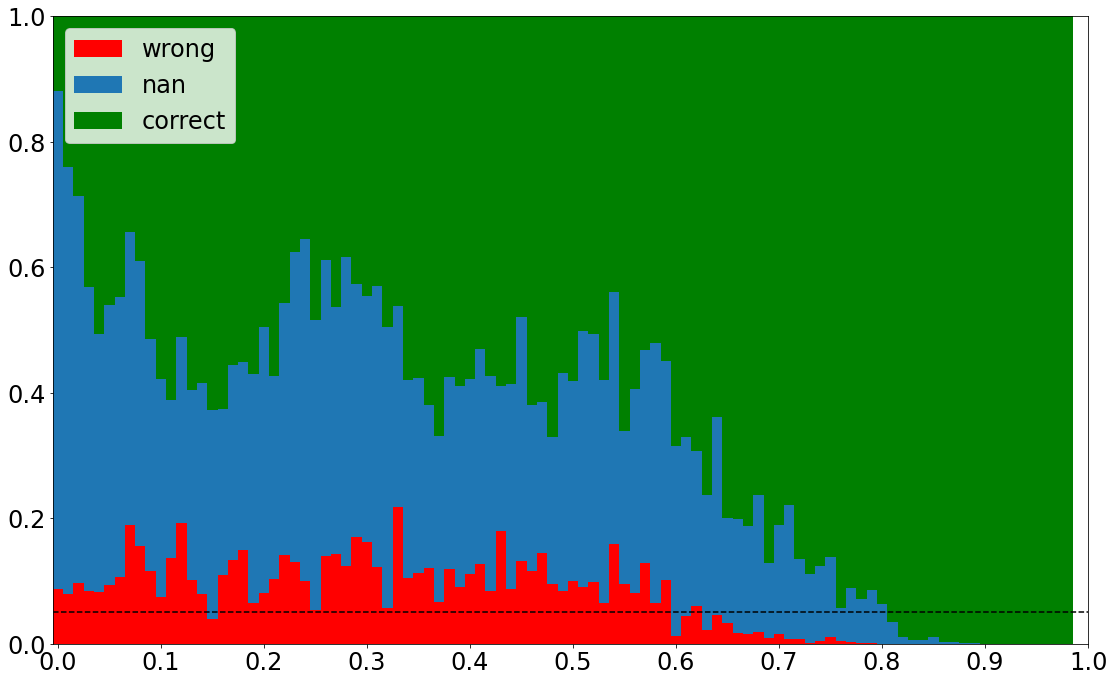

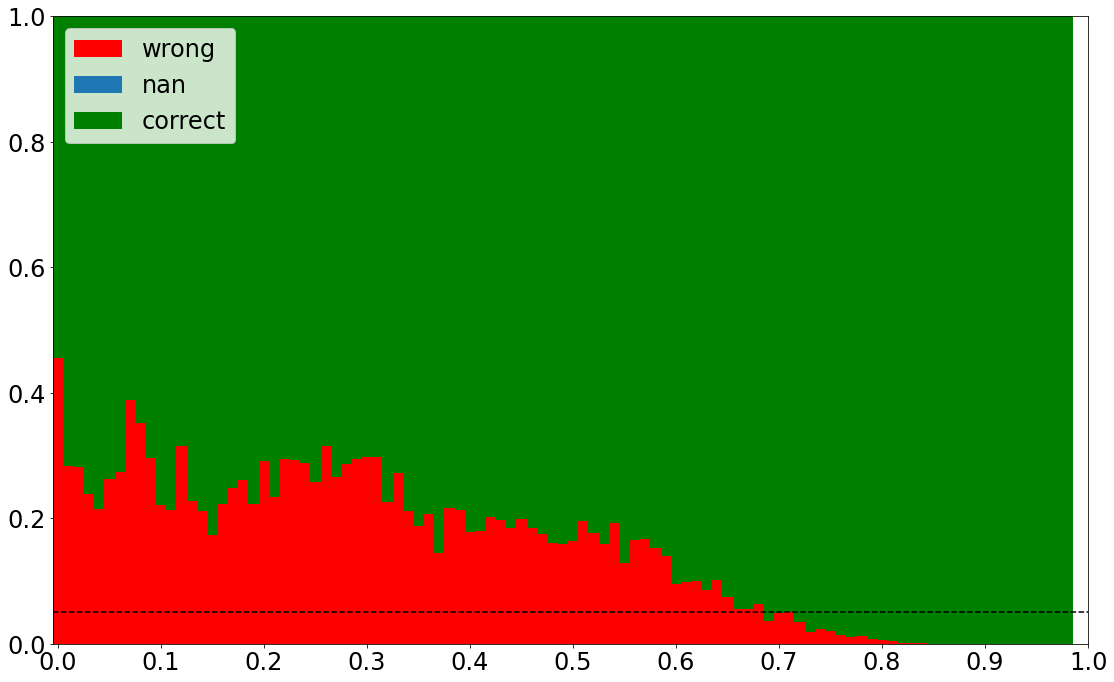

In [74]:
plot_binned_aggr(9, 15, 't')
plot_binned_aggr(9, 15, 'w')
plot_binned_aggr(9, 15, 'm')

## Figure 10: Aggregated Mistaktes T-Test

In [75]:
frac_mistakes_t = np.zeros((24,10))
frac_mistakes_w = np.zeros((24,10))
for fid in range(1,25):
    dt = pd.read_csv(f"Datatables/F{fid}_cma_mistakes.csv", index_col=0)
    dt = dt[dt['ss'] == 15] 
    dt['t_wrong'] = 1-dt.t_nan-dt.t_correct
    dt['w_wrong'] = 1-dt.w_nan-dt.w_correct
    
    for idx in range(10):    
        low = idx*0.1
        high = idx*0.1+0.1

        dt_temp = dt[(low <= dt['Mean difference']) & (dt['Mean difference'] < high)]
        frac_mistakes_t[fid-1,idx] = np.sum(dt_temp['t_wrong']>0.05)/len(dt_temp)
        frac_mistakes_w[fid-1,idx] = np.sum(dt_temp['w_wrong']>0.05)/len(dt_temp)

/tmp/ipykernel_993/48509691.py:14: RuntimeWarning: invalid value encountered in long_scalars
  frac_mistakes_t[fid-1,idx] = np.sum(dt_temp['t_wrong']>0.05)/len(dt_temp)
/tmp/ipykernel_993/48509691.py:15: RuntimeWarning: invalid value encountered in long_scalars
  frac_mistakes_w[fid-1,idx] = np.sum(dt_temp['w_wrong']>0.05)/len(dt_temp)


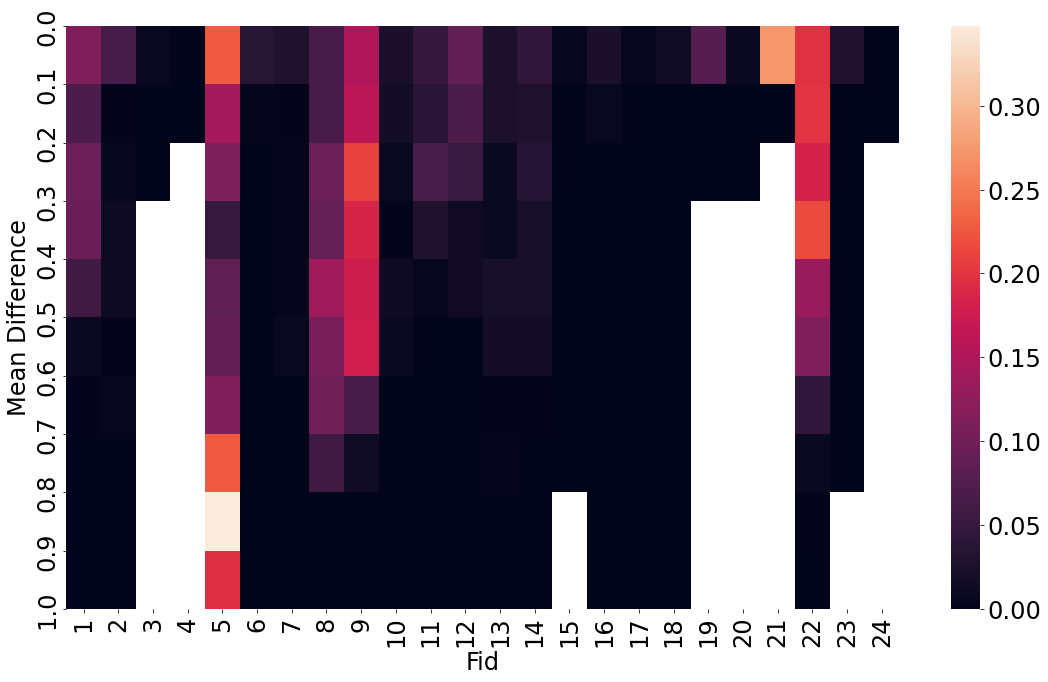

In [76]:
plt.figure(figsize=(16,10))
sbs.heatmap(np.transpose(frac_mistakes_t))
plt.xticks([i+0.5 for i in range(24)], range(1,25))
plt.yticks([i for i in range(11)], [f"{i*0.1:.1f}" for i in range(11)])
plt.ylabel("Mean Difference")
plt.xlabel("Fid")
plt.tight_layout()
plt.savefig("Figures_reproduced/Frac_mistakes_t_test_mean_diff_transpose.pdf")

## Figure 11: CDF of Perf Loss

In [77]:
dt_tests4 = pd.read_csv("Datatables/dt_tests_all.csv", index_col=0)

#Alternatively, use the following to construct this table based on all of the previous ones:

# dt_ftest = pd.read_csv("Datatables/irace_verification_mistakes_overall_v2.csv", index_col=0)
# dt_ttest = pd.DataFrame()
# for fid in range(1,25):
#     for ss in [2,5,10,15,25,50]:
#         temp_dt = pd.read_csv(f"Datatables/last_race_partial/F{fid}_S{ss}_aoc_t-test.csv", index_col=0)
#         dt_ttest = dt_ttest.append(temp_dt)
# dt_ftest['Test'] = 'f-test'
# dt_tests = dt_ttest.append(dt_ftest)
# df_group_selection_mean = pd.read_csv("Datatables/df_group_selection_mean_fixed.csv", index_col=0)
# df_group_selection_mean['Used Samples'] = df_group_selection_mean['Sample Size']*33
# df_group_selection_mean['Test'] = 'Sampling Only'
# dt_tests3 = dt_tests.append(df_group_selection_mean)
# dt_halving['Test'] = dt_halving['Type']
# dt_tests4 = dt_tests3.append(dt_halving)

/home/diedi/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/diedi/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


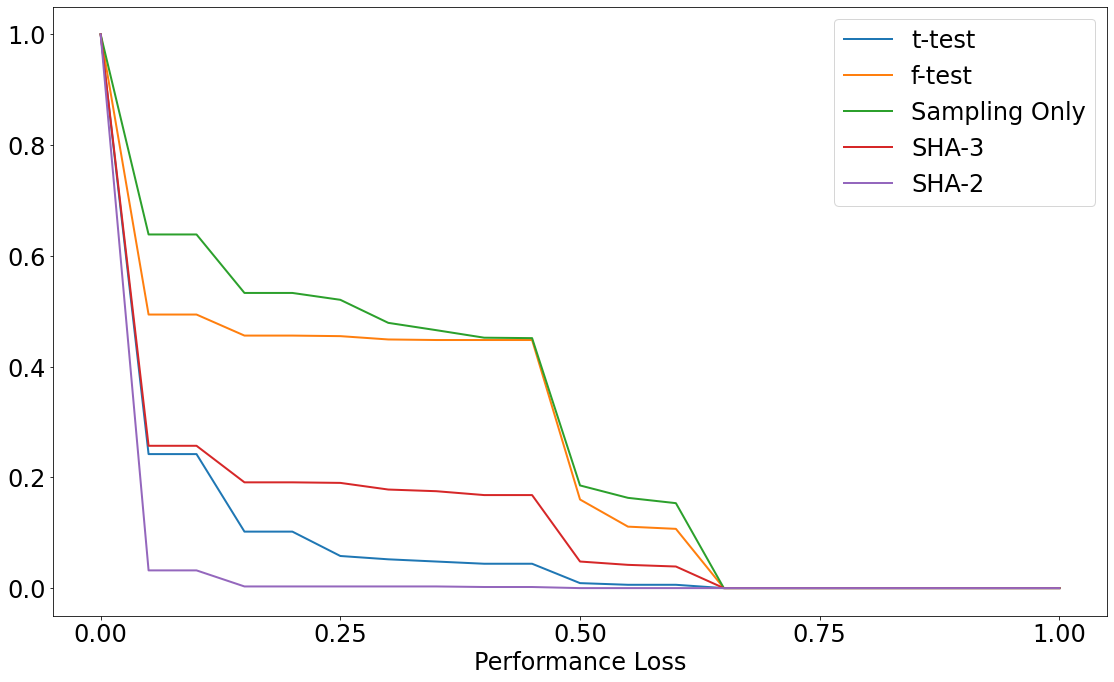

In [81]:
ss = 15
fid = 22

plt.figure(figsize=(16,10))
bins = np.arange(0,1.00000001,0.05)

for type_ in ['t-test','f-test','Sampling Only', 'SHA-3', 'SHA-2']:
    dt_temp = dt_tests4[(dt_tests4['Sample Size'] == ss) & (dt_tests4['Fid'] == fid) & (dt_tests4['Test'] == type_)]
    max_len = len(dt_temp)
    plt.plot([1-np.sum(dt_temp['Perf Loss'] < b)/max_len for b in bins], label=f'{type_}', lw=2)
plt.legend()
plt.xlabel("Performance Loss")
plt.xticks(range(len(bins))[::5],[f"{x:.2f}" for x in bins[::5]])
plt.tight_layout()
plt.savefig(f"Figures_reproduced/F{fid}_FT{ss}_CDFLoss.pdf")

## Figure 12: AUC of Perf Loss Relative to Budget

In [83]:
records = []
for fid in range(1,25):
    for ft in [2,5,10,15,25,50]:
        dt_sub = dt_tests4[(dt_tests4['Sample Size'] == ft) & (dt_tests4['Fid'] == fid)]
        for test in ['SHA-2', 'SHA-3', 'Sampling Only', 'f-test', 't-test']:
            dt_temp = dt_sub[dt_sub['Test'] == test]
            aoc = np.sum([1-np.sum(dt_temp['Perf Loss'] < b)/len(dt_temp) for b in bins])
            avg_samples = np.mean(dt_temp['Used Samples'])
            records.append([aoc, avg_samples, test, fid, ft])

In [84]:
dt_aoc = pd.DataFrame.from_records(records, columns=['AUC','Samples', 'Test', 'Fid', 'FT'])

In [85]:
dt_aoc['AUC'] = dt_aoc['AUC']-1 #Remove the value at 0, since that is an atrifact of the binning used

In [87]:
for fid in [9,15,22]:
    plt.figure(figsize=(16,10))
    sbs.scatterplot(data=dt_aoc[dt_aoc['Fid']==fid], x='Samples', y='AUC', hue='Test', style='FT', s=350)
    plt.xscale('log')
    plt.xlabel("Average Used Samples")
    plt.tight_layout()
    plt.savefig(f"Figures_reproduced/Perf_loss_AUC_F{fid}.pdf")
    plt.close()